In [1]:
import numpy as np
import pennylane as qml
import torch as th
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
# --- 2. SETUP FOR ACADEMIC STYLE ---

font1 = 18
font2 = 16
font3 = 20

plt.rcParams.update({
    #"text.usetex": True,
    #"font.family": "serif",
    #"font.serif": ["Computer Modern Roman"],
    "font.size": font1,
    "axes.labelsize": font3,
    "legend.fontsize": font1,
    "xtick.labelsize": font2,
    "ytick.labelsize": font2,
    "figure.titlesize": font3,
    "text.latex.preamble": r"\usepackage{amsmath} \usepackage{amssymb} \usepackage{amsfonts}",
    # Line Widths
    "lines.linewidth": 1.7, # Main plot lines
    "axes.linewidth": 1.,  # Axis spine width
    "grid.linewidth": 1.0,  # Grid line width
    
    # Tick/Marker Properties
    "xtick.major.width": 1.5,
    "ytick.major.width": 1.5,
})

In [12]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# We'll use the same hardware-efficient ansatz from the VQE code
def hardware_efficient_ansatz(params, wires):
    """
    A simple hardware-efficient ansatz.
    """
    num_layers = params.shape[0]
    num_qubits = len(wires)

    for layer in range(num_layers):
        for i in range(num_qubits):
            qml.RY(params[layer, i], wires=i)
        for i in range(num_qubits - 1):
            qml.CNOT(wires=[i, i + 1])

def calculate_gradient_variance(num_qubits, num_layers, num_samples=100):
    """
    Calculates the variance of a gradient component for a randomly
    initialized circuit.

    Args:
        num_qubits (int): The number of qubits in the circuit.
        num_layers (int): The number of layers in the ansatz.
        num_samples (int): The number of random initializations to average over.

    Returns:
        float: The variance of the gradient of the first parameter.
    """
    dev = qml.device("lightning.qubit", wires=num_qubits)

    # We define a simple cost function: the expectation value of PauliZ on the first qubit.
    # This is a "local" cost function. The effect is even stronger for "global" cost functions.
    @qml.qnode(dev)
    def circuit(params):
        hardware_efficient_ansatz(params, wires=range(num_qubits))
        return qml.expval(qml.PauliZ(0))

    # We will calculate the gradient with respect to the first parameter
    grad_fn = qml.grad(circuit)
    
    gradients = []
    for _ in range(num_samples):
        # Initialize with new random parameters for each sample
        params = np.random.uniform(0, 2 * np.pi, (num_layers, num_qubits))
        
        # Calculate the gradient for this initialization
        gradient = grad_fn(params)
        
        # We only care about the gradient of the first parameter
        gradients.append(gradient[0, 0])
        
    return np.var(gradients)


In [5]:
# --- Original setup ---
qubit_range = range(2, 15, 2)
layer_range = [4, 6, 8, 10, 12, 14, 16, 18]
results = {layers: [] for layers in layer_range}
num_samples = 5000 # Assuming this is fixed

In [ ]:
from joblib import Parallel, delayed
import itertools

# 1. Create a list of all (qubit, layer) combinations
# itertools.product creates the Cartesian product of the two ranges.
all_jobs = list(itertools.product(qubit_range, layer_range))
print(f"Total jobs to run: {len(all_jobs)}")

# 2. Run all jobs in a single parallel call
print("\n--- Running all jobs in parallel ---")
all_variances = Parallel(n_jobs=-1, verbose=11)(
    delayed(calculate_gradient_variance)(n_qubits, num_layers, num_samples)
    for n_qubits, num_layers in all_jobs
)

# 3. Reconstruct the results dictionary
results = {layers: [] for layers in layer_range}
for i, (n_qubits, num_layers) in enumerate(all_jobs):
    # Find the correct list in the dictionary and append the result
    # This is a bit complex; a simpler way is shown below
    if num_layers == 2:
        results[2].append(all_variances[i])
    elif num_layers == 5:
        results[5].append(all_variances[i])
    elif num_layers == 10:
        results[10].append(all_variances[i])

# A simpler way to reconstruct the dictionary
results_simple = {layers: [] for layers in layer_range}
# zip pairs each job with its result
for (n_qubits, num_layers), var in zip(all_jobs, all_variances):
    results_simple[num_layers].append(var)


print("\n--- Final Results (reconstructed) ---")
print(results_simple)

Total jobs to run: 56

--- Running all jobs in parallel ---


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  15 out of  56 | elapsed:   27.1s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  21 out of  56 | elapsed:   38.2s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  27 out of  56 | elapsed:   53.3s remaining:   57.3s
[Parallel(n_jobs=-1)]: Done  33 out of  56 | elapsed:  1.2min remaining:   51.7s
[Parallel(n_jobs=-1)]: Done  39 out of  5


--- Final Results (reconstructed) ---
{4: [np.float64(0.2646157570109534), np.float64(0.16237954942289132), np.float64(0.1708952278659684), np.float64(0.16545618625427713), np.float64(0.16691481409119202), np.float64(0.16545954289568057), np.float64(0.1666979541292917)], 6: [np.float64(0.22368744113578545), np.float64(0.08616502812072101), np.float64(0.07781340540121316), np.float64(0.07974339741587093), np.float64(0.08073991664254122), np.float64(0.07967648261358157), np.float64(0.08278287670577146)], 8: [np.float64(0.22207750688993755), np.float64(0.06551949359464845), np.float64(0.039252421543018286), np.float64(0.038152096152165894), np.float64(0.03733295767834637), np.float64(0.03779148336582408), np.float64(0.039732647845430506)], 10: [np.float64(0.2165486343599789), np.float64(0.05894281836732773), np.float64(0.02367929901227792), np.float64(0.019698975998235783), np.float64(0.020030620810699493), np.float64(0.018865253858556467), np.float64(0.018649379829991417)], 12: [np.floa

[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:  3.5min finished


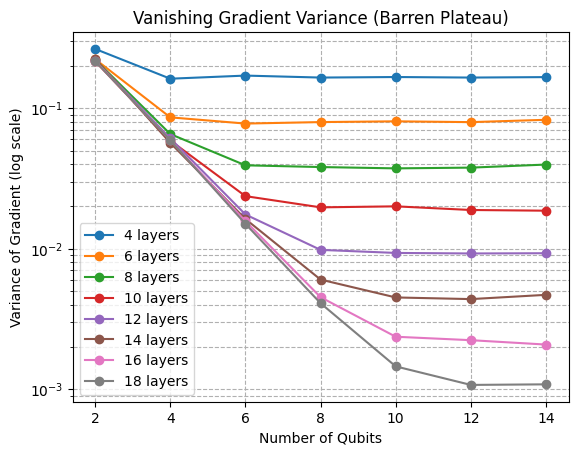

In [16]:
# --- Plotting the results ---
fig, ax = plt.subplots()
for num_layers, variances in results_simple.items():
    ax.plot(list(qubit_range), variances, 'o-', label=f'{num_layers} layers')

ax.set_yscale('log') # Use a log scale to see the exponential decay
ax.set_title("Vanishing Gradient Variance (Barren Plateau)")
ax.set_xlabel("Number of Qubits")
ax.set_ylabel("Variance of Gradient (log scale)")
ax.grid(True, which="both", ls="--")
ax.legend()
plt.show()

In [31]:
import pickle

with open("results_simple.pkl", "wb") as f:
    pickle.dump(results_simple, f)

In [3]:
import pickle

with open("../local_data/results_simple.pkl", "rb") as f:
    results_simple = pickle.load(f)

In [9]:
import seaborn as sns
sns.color_palette("muted")

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

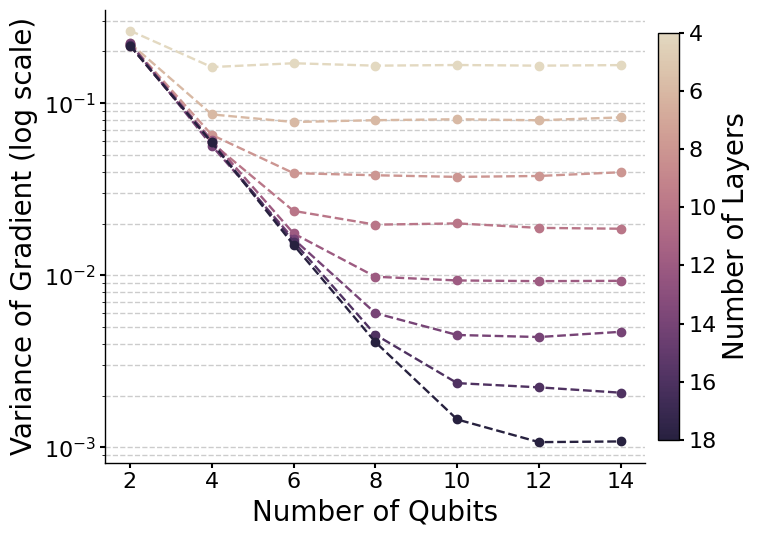

In [44]:
import matplotlib.cm as cm # We need this for the mappable object
import matplotlib.colors as mcolors # We need this for the normalizer

# Create a figure and a single subplot with a specified size
fig, ax = plt.subplots(figsize=(8, 6))

colors = sns.color_palette("ch:s=-.2,r=.6", 8)
cmap = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)

# --- 2. PLOTTING THE DATA ---
# Loop through your results and plot with specific styles
for i, (num_layers, variances) in enumerate(results_simple.items()):
    ax.plot(
        list(qubit_range),
        variances,
        marker='o',         # Add a distinct marker
        linestyle='--',      # Use a dashed line
        color=colors[i % len(colors)], # Cycle through the defined colors
        label=f'{num_layers} layers'
    )


# --- 3. SCALES AND LABELS ---
ax.set_yscale('log') # Use a log scale to see the exponential decay
#ax.set_title("Vanishing Gradient Variance (Barren Plateau)")
ax.set_xlabel("Number of Qubits")
ax.set_ylabel("Variance of Gradient (log scale)")


# --- 4. STYLING AND AESTHETICS ---
# Apply the clean aesthetic by removing top and right spines
ax.spines[['right', 'top']].set_visible(False)

# Customize grid to be horizontal only, with a lighter style
ax.grid(axis='y', linestyle='--', color='gray', alpha=0.4, which='both')

# Customize ticks to match the data points on the x-axis
ax.set_xticks(list(qubit_range))
ax.tick_params(axis='both', which='major')


# --- 5. CREATE A FIGURE-LEVEL LEGEND ---
# Get handles and labels from the axis to create a single figure legend
handles, labels = ax.get_legend_handles_labels()
# Place the legend at the top right of the figure canvas
#fig.legend(handles,labels,loc='upper right',ncol=1,frameon=True,bbox_to_anchor=(0.98, 0.9))

min_layers = min(results_simple.keys())
max_layers = max(results_simple.keys())
# Create a normalizer object to map layer numbers to the 0-1 range
norm = mcolors.Normalize(vmin=min_layers, vmax=max_layers)
# Create a ScalarMappable object that understands how to map numbers to colors
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
# Add the color bar to the figure, linking it to the mappable object
cbar = fig.colorbar(sm, ax=ax, pad=0.02, shrink=0.9)
cbar.set_label("Number of Layers")
cbar.ax.invert_yaxis()

# --- 6. FINALIZE AND SAVE ---
# Adjust layout to prevent labels from overlapping and make space for the legend
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Save the figure to a PDF with high quality (optional)
# fig.savefig("barren_plateau_variance.pdf", format="pdf", bbox_inches='tight')